## Wakefield simulation using Wakis

In this example we will set up and simulate start-to-end an accelerator cavity above pipe cutoff frequency. To simulate this, we need the use of **Open Boundaries** that mimic and infinite pipe for the modes above cutoff to propagate

### Notes on Open boundaries: Perfect Matching Layers
A **Perfectly Matched Layer (PML)** is an artificial absorbing layer used in finite-difference and finite-element electromagnetic simulations (e.g., FDTD, FIT) to mimic open boundaries by preventing reflections at the edges of the computational domain. 

The PML works by **transforming the coordinates into a complex space**, which attenuates outgoing waves without reflection. To achieve this, the **electrical conductivity $ \sigma $** (and magnetic conductivity $ \sigma^* $ if needed) inside the PML is gradually increased along the thickness of the layer — typically using a polynomial ramp such as:

$$
\sigma(x) = \sigma_{\text{max}} \left( \frac{x}{d} \right)^m
$$

where $ x $ is the depth into the PML, $ d $ is the total PML thickness, $ \sigma_{\text{max}} $ is the peak conductivity, and $ m $ (commonly 2–4) controls the smoothness of the ramp. This graded profile ensures impedance matching and gradual absorption, minimizing reflections across a wide frequency range and for oblique incidence.

<div style="text-align:center">
  <img src="https://codimd.web.cern.ch/uploads/upload_377b25730e2b4ec04c803bbab82562da.gif" width="400">
</div>

In [3]:
import numpy as np                  # arrays and operations
import pyvista as pv                # for 3d plotting
import matplotlib.pyplot as plt     # for 1d, 2d plotting
from tqdm import tqdm

from wakis import GridFIT3D         # grid generation
from wakis import SolverFIT3D       # electromagnetic solver
from wakis import WakeSolver        # wakefield and impedance calculation

flag_plot_pyvista = True

### Reading and/or generating geometry with `PyVista`

In [4]:
# ---------- Domain setup ---------

# Pre-generated geometry in STL / OBJ / STEP format
stl_cavity = 'data/cavity_vacuum.stl' 
stl_shell = 'data/cavity_shell.stl'

# We can read them and plot them with pyvista
if flag_plot_pyvista:
    pl = pv.Plotter()
    pl.add_mesh(pv.read(stl_shell),color='tab:orange', specular=0.5, smooth_shading=True)
    pl.add_mesh(pv.read(stl_cavity),color='tab:blue', opacity=0.5, specular=0.5, smooth_shading=True)
    pl.set_background('mistyrose', top='white')
    pl.camera_position = 'zx'
    pl.show()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783eda394e50_0&reconnect=auto" class="pyvi…

Again with PyVista, we can generate our geometry in Python using the Constructive Solid Geomtry (CSG) principles:

In [ ]:
# Adding new solids to out domain with Constructive Solid Geometry (CSG)
letters = pv.Text3D('CEI', 
                    width = 0.25,
                    height = 0.2,
                    normal = (0,1,0),
                    center = (0,0,0),
                    ).rotate_y(90).translate([0, 0, 0.15])

stl_letters = 'data/letters.stl'
letters.save(stl_letters)


In [6]:
# We can quickly plot the solids in 3D:
geometry = letters + pv.read(stl_cavity) + pv.read(stl_shell)

if flag_plot_pyvista:
    pl = pv.Plotter()
    pl.add_mesh_clip_box(geometry, color='white', rotation_enabled=False)
    pl.add_axes()
    pl.camera_position = 'zx'
    pl.show()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783e8c9625d0_1&reconnect=auto" class="pyvi…

In [ ]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 80
Ny = 80
Nz = 200
print(f"Total number of cells: {Nx*Ny*Nz}")

stl_solids = {'cavity': stl_cavity, 
              'shell': stl_shell,
              'letters' : stl_letters}

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30],  # lossy metal [eps_r, mu_r, sigma] 
                 'letters' : 'pec', # [10, 1.0],  # dielectric [eps_r, mu_r] 
                }

xmin, xmax, ymin, ymax, zmin, zmax = geometry.bounds

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                use_mpi=False,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                #stl_scale=stl_scale,      # solids can be rotated, scaled or translated if needed 
                #stl_rotate=stl_rotate,
                #stl_translate=stl_translate
                )

Total number of cells: 774400
Generating grid...
Importing STL solids...
Importing stl solids...


In [8]:
# Built-in method to inspect the grid
if flag_plot_pyvista:
    grid.inspect()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783ed3411110_2&reconnect=auto" class="pyvi…

In [ ]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

n_pml = 10  # number of PML cells
solver = SolverFIT3D(grid,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=False, # activate GPU
                     n_pml=n_pml,   # number of PML cells
                     )


Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.0160045623779297 s


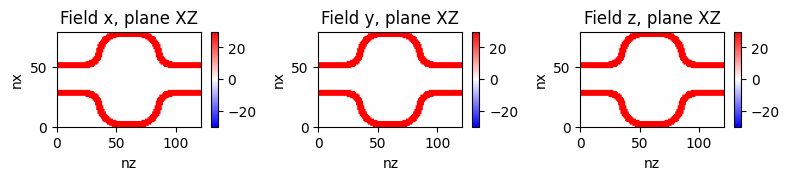

In [11]:
# Built-in method in `Field` class
# to inspect material tensors (ieps, imu, sigma)
# or EM fields E, H, J before simulating

solver.sigma.inspect(plane='XZ', cmap='bwr')

## Running with a routine e.g. Wakefield solver

We need to setup our WakeSolve class with the desired beam parameters and wakelength: 
* It will take care of saving the fields for the wake potential and impedance calculations

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 5e-2      #[m] -> f_max = beta*c/3sigmaz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 30.  # [m]
skip_cells = 10   # no. cells
results_folder = f'results_wl{int(wakelength)}/'
wake = WakeSolver(wakelength=wakelength,
                  q=q, 
                  sigmaz=sigmaz, 
                  beta=beta,
                  xsource=xs, ysource=ys, 
                  xtest=xt, ytest=yt,
                  skip_cells=skip_cells,           # Skip cells for wake potential integration at the boundary 
                  results_folder=results_folder,   
                  Ez_file=results_folder+'Ez.h5')

In [ ]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=True, # activate GPU
                     )

In [ ]:
# Some built-in plotting kwargs:
plotkw2D = {'title':'img/E_z', 
            'add_patch':['cavity'], 'patch_alpha':0.9,
            'patch_reverse' : True, 
            'vmin':0, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : 'jet',
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

# Solver run
solver.wakesolve(wakelength=wakelength, 
                 plot=False, # turn False for speedup
                 plot_every=30, plot_until=3000, **plotkw2D
                 )

Once the simulation is finished, we can plot the results:

In [ ]:
# Plot longitudinal wake potential and impedance
fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()
fig1.savefig(results_folder+'longitudinal.png')
#plt.show()


In [ ]:
# Plot transverse x wake potential and impedance
fig2, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Abs][$\Omega$]', color='tab:green')
ax[1].legend()

fig2.tight_layout()
fig2.savefig(results_folder+'001_transverse_x.png')
#plt.show()

In [ ]:
# Plot transverse y wake potential and impedance
fig3, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
ax[1].legend()

fig3.tight_layout()
fig3.savefig(results_folder+'transverse_y.png')
#plt.show()

Or plot the field at the last timestep at different transverse positions:

In [ ]:
# %matplotlib ipympl
# Plot Electric field component in 2D using imshow
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.1, 0.2, 0.35, 0.5, 0.6], 
              xscale='linear', yscale='linear',
              off_screen=False, title=results_folder+'Ez1d')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.1, 0.9))) # CST's colormap

# Plot Electric field component in 2D using imshow
solver.plot2D(field='E', component='z', 
              plane='ZX', pos=0.5, 
              cmap=cmap, vmin=-100, vmax=100., interpolation='hanning',
              add_patch='cavity', patch_reverse=True, patch_alpha=0.8, 
              off_screen=False)

## Extrapolating the partially decayed simulation w/ `IDDEFIX`

The [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) (Impedance Determination through Differential Evolution FItting and eXtrapolation) python package will take the partially decayed wake and give back the fully decayed wake using the **Resonator formalism** and **Diferential Evolution's** algorithms powered with `scipy` and `pymoo`

With IDDEFIX, we can find the main resonators and use Evolutionary Algorithms to fit them to the partially decayed formalism:

In [2]:
import iddefix
from scipy.constants import c

In [ ]:
# We can recompute the impedance with less samples to increase the EA speed
wake.calc_long_Z(samples=1001, fmax=2e9)

In [ ]:
# get bounds for the Differential Evolution fitting
bounds = wake.get_SmartBounds(freq_data=wake.f, impedance_data=wake.Z,
                        minimum_peak_height=500, distance=3, inspect_bounds=True,
                        Rs_bounds=[0.8, 10], Q_bounds=[0.5, 5], fres_bounds=[-0.01e9, +0.01e9]
                        )

In [ ]:
DE_model = wake.get_DEmodel_fitting(freq_data=wake.f, impedance_data=wake.Z, 
                                    plane='longitudinal', dim='z', 
                                    parameterBounds=bounds.parameterBounds, N_resonators=bounds.N_resonators, 
                                    DE_kernel='CMAES', maxiter=1e5, cmaes_sigma=0.01, popsize=150, tol=1e-3,
                                    use_minimization=True, minimization_margin=[0.3, 0.2, 0.01])

### Plot the extrapolation result

In [ ]:
# retrieve the wake potential, function and impedance analytically using the resonator formalism
from scipy.constants import c as c_light

new_wakelength = 100 # [m]
s, wake_potential = wake.get_extrapolated_wake(wakelength=new_wakelength, sigma=sigmaz/c_light, use_minimization=True)
t, wake_function = wake.get_extrapolated_wake_function(wakelength=new_wakelength, use_minimization=True)
f, impedance = wake.get_extrapolated_impedance(wakelength=new_wakelength, use_minimization=True)

In [ ]:

fig, ax = plt.subplots(2,1, figsize=[8,8], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].plot(s*1e2, wake_potential, c='r', lw=3, alpha=0.5, label='Wakis DE extrapolation')
ax[0].plot(t*c_light*1e2, wake_function, c='', lw=1.5, alpha=0.5, label='Wakis DE extrapolation')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Wakis - Re')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', lw=1.5, ls='--', label='Wakis - Imag')

ax[1].plot(f*1e-9, np.real(impedance), c='b', lw=3, alpha=0.5, label='Wakis DE - Re')
ax[1].plot(f*1e-9, np.imag(impedance), c='b', lw=3, ls='--', alpha=0.5, label='Wakis DE - Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

In [ ]:
#%matplotlib ipympl

# Retrieve partially decayed wake potential
WP_pd = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c, use_minimization=False)
WP_pd_min = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c)

# Retrieve partially decayed impedance
f_pd = np.linspace(0, 1.2e9, 10000)
Z_pd = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=False)
Z_pd_min = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=True)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)

ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(wake.s, -WP_pd*1e-12, c='tab:blue', alpha=0.8, lw=1.5, label='DE wake potential')
ax[0].plot(wake.s, -WP_pd_min*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min wake potential')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='-', c='k', lw=1.5, label='Real')
#ax[1].plot(f*1e-9, np.imag(Z), ls=':', c='k', lw=1.5, label='Imag')
#ax[1].plot(f*1e-9, np.real(Z_pd), c='tab:blue', label='Abs')

ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='-', c='tab:blue', alpha=0.8, lw=1.5, label='DE Real')
#ax[1].plot(f_pd*1e-9, np.imag(Z_pd), ls=':', c='tab:blue', alpha=0.6, lw=1.5, label='DE Imag')

ax[1].plot(f_pd*1e-9, np.real(Z_pd_min), ls='-', c='tab:red', alpha=0.6, lw=1.5, label='DE+min Real')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

And analytically reconstruct the desired wakelength

In [ ]:
# We can compare it with a longer simulation to verify the extrapolation
wake100 = WakeSolver()
wake100.load_results('results_wl100/')

In [ ]:
t_fd = np.linspace(wake.s[0]/c, 100/c, 10000)
WP_fd = DE_model.get_wake_potential(t_fd, sigma=10e-2/c)

f_pd = np.linspace(0, 1.5e9, 10000)
Z_pd = DE_model.get_impedance(f_pd, wakelength=100)

f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
#ax[0].plot(wake100.s, wake100.WP, c='k', alpha=0.8, label='Wakis wl=100 m')
ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(t_fd*c, -WP_fd*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min 100m')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='k', alpha=0.5, label='Wakis wl=30 m')
#ax[1].plot(wake100.f*1e-9, np.real(wake100.Z), c='k', label='Wakis wl=100 m')
ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='--', c='tab:blue', alpha=0.8, lw=1.5, label='DE+min wl=100m')
#ax[1].plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:red', alpha=0.8, lw=1.5, label='DE+min wl=inf')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

And finally save to a txt our fully decayed impedance:

In [ ]:
f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)
DE_model.save_txt('003_fully_decayed_impedance.txt', f_fd, Z_fd)

## Computing the beam-induced heating w/ `BIHC`

Generate beam parameters with `BIHC`

Let's imagine our CAP cavity is installed in the LHC and we need to estimate if the power loss due to impedance is high enough that it can melt or damage the component

First we define the beam filling scheme and build our beam:

In [ ]:
import bihc

In [ ]:
# We can import it from BIHC's library by
from bihc.fillingschemes import fillingSchemeLHC_standard
from bihc.fillingschemes import fillingSchemeLHC_8b4e

# Or use an LPC file from the LPCTool database
LPCfile = 'data/25ns_2464b_2452_1842_1821_236bpi_12inj_hybrid.csv' 

In [ ]:
# Create beam object
bl = 1.2e-9                 # bunch length [s]
Np = 2.3e11                 # bunch intensity [protons/bunch]
bunchShape = 'q-GAUSSIAN'   # bunch profile shape in time 
qvalue = 3/5                # value of q parameter in the q-gaussian distribution
fillMode = 'FLATTOP'        # Energy
fmax = 2e9                  # Maximum frequency of the beam spectrum [Hz]

# If using a filling scheme: 
fillingScheme = fillingSchemeLHC_standard(ninj=9, ntrain=4, nbunches=72)
beam = bihc.Beam(Np=Np, bunchLength=bl, fillingScheme=fillingScheme, # LPCfile=LPCfile, then fillingScheme parameter is not needed
                bunchShape=bunchShape, qvalue=qvalue, 
                machine='LHC', fillMode=fillMode, spectrum='numeric', fmax=fmax)


print(f'* Number of bunches used: {np.sum(fillingScheme)}')
print(f'* Total intensity: {np.sum(fillingScheme)*Np:.2e} protons')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[14,6])

t, prof = beam.longitudinalProfile
ax[0].plot(t*1e6, prof*beam.Np,)
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Profile Intensity [protons]')

f, spectrum = beam.spectrum
ax[1].plot(f*1e-9, spectrum*beam.Np*np.sum(fillingScheme), c='r')
ax[1].set_xlabel('Frquency [GHz]')
ax[1].set_ylabel('Spectrum Intensity [protons]')
ax[1].set_xlim((0, 2.0))

The beam induced heating depends on the interaction of the beam power spectrum and the beam-coupling impedance:

$$
P_{loss} = 2 (f_0 eN_{beam})^2 \cdot \sum_{p=0}^{+\infty} |\Lambda(p\omega_0)|^2 Re[Z_z(p \omega_0)]
$$

To assess it visually we can plot them together:


In [ ]:
# We create an impedance object with BIHC:
Z = bihc.Impedance(f=f_fd, Z=Z_fd)

In [ ]:
# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
#ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=0, ymax=1.1)

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
axx.set_ylim(ymin=1e-0) 
#axx.set_yscale('log')

axx.legend([l0, l1], [f'$\Lambda^2$ Power spectrum', 'Re(Z) CEI logo impedance'], loc=0)

fig.tight_layout()

### Calculate Beam-Induced power loss
With `BIHC` we can simply calculate the power loss by `beam.getPloss(Z)`. 

However, due to inacuracies in the wakefield simulation or the CAD model, or to account for changes in the revolution frequency during operation, `BIHC` also performs a **statistical analysis** by rigidly shifting the impedance curve `beam.getShiftedPloss(Z, shift=shift)` to account for different overlaps with the beam spectral lines:

In [ ]:
print('Calculate beam-induced heating of CAP-cavity impedance')
print('----------------------------------------------------')
# Get unshifted ploss 
ploss, ploss_density = beam.getPloss(Z) 
print(f'Dissipated power (no-shift): {ploss:.3} W')

# Get min/max power loss with rigid shift
shift = 20e6  # distance between shift steps [Hz]
shifts, power = beam.getShiftedPloss(Z, shift=shift)

print(f'Minimum dissipated power: P_min = {np.min(power):.3} W, at step {shifts[np.argmin(power)]}')
print(f'Maximum dissipated power: P_max = {np.max(power):.3} W, at step {shifts[np.argmax(power)]}')
print(f'Average dissipated power: P_mean = {np.mean(power):.3} W')

We can now retrieve and plot the impedance curve that gives the maximum power loss. We can observe that when the peak at lower frequency is shifted and placed exactly on top of the beam spectral line, the power loss dramatically increases

In [ ]:
# Get unshifted ploss max
Z_max = beam.Zmax

# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')
l2, = axx.plot(Z_max.f/1e9, Z_max.Zr, color='b', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
#ax.set_ylim(ymin=1e-3, ymax=1.1)
#ax.set_yscale('log')

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
#axx.set_ylim(ymin=1e-1, ymax=1e5) 
#axx.set_yscale('log')

axx.legend([l0, l1, l2], [f'$\Lambda^2$ Power spectrum', 'Re(Z) CEI logo impedance', 'Re(Z) Shifted CEI logo impedance'], loc=0)

fig.tight_layout()

We can also plot the power loss by frequency with the power loss density:

In [ ]:
fig, ax = plt.subplots(figsize=[10,7])

# Unshifted impedance
ploss, ploss_density = beam.getPloss(Z) 

# Shifted impedance
ploss_max, ploss_density_max = beam.getPloss(Z_max) 

l1, = ax.plot(np.linspace(0, Z_max.f.max()/1e9, len(ploss_density_max )), ploss_density_max , color='r', marker='v', lw=3, alpha=0.8)
l0, = ax.plot(np.linspace(0, Z.f.max()/1e9, len(ploss_density )), ploss_density , color='k', marker='v', lw=3, alpha=0.8)

ax.set_ylabel('Power by frequency [W]', color='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=1e-1, ymax=1e4)
ax.grid(which='minor', axis='y', alpha=0.8, ls=':')

ax.legend([l0, l1, l2], [f'Ploss', 'Ploss Max.'], loc=1)
ax.text(0.3, 0.9, f'Ploss avg = {round(np.mean(power ),2)} W \n Ploss max. = {round(np.max(power ),2)} W',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        bbox ={'facecolor':'white','alpha':0.6, 'pad':10},
        color='k', fontsize=14)

fig.suptitle('Power loss by frequency')
fig.tight_layout()

If the CAP cavity was placed in a common-beam chamber, it would see the effect of **2 beam power loss**:
$$
P_{loss}(s) = 
(2 f_0 e N_{beam})^2 \cdot \sum_{p=0}^{+\infty} |\Lambda(p\omega_0)|^2 \cdot (Re[Z^0_z(p \omega_0)] + \\
[\Delta y_1(s) + \Delta y_2(s)]Re[Z^1_z(p \omega_0)]) \cdot (1 - cos(p \omega_0 \tau_s))
$$

<br>



The beam-induced heating in this case is a function of the distance with the interaction point (IP) and can be greater than a factor 2 of the 1-beam case. 

We can compute this with `BIHC` too:

In [ ]:
 #       2 beam case
# ----------------------
# Defining the phase shift array for LHC
c = 299792458 # Speed of light in vacuum [m/s]
ring_circumference =  26658.883   #[m]

start = -3.5 #m
stop = 3.5 #m
resolution = 0.001 #m power2b

s = np.arange(start, stop, resolution)
tau_s = 2*s/c # Phase shift array [s]

power2b = beam.get2BeamPloss(Z, tau_s=tau_s)
power2b_max = beam.get2BeamPloss(Z_max, tau_s=tau_s)

In [ ]:
# Plot power los vs distance from IP, qgaussian
fig, ax = plt.subplots(figsize=[12,5])

ax.plot(s, power2b_max, label="2-b Ploss Max.", c='b', ls='-', alpha=0.7)
ax.plot(s, power2b, label="2-b Ploss ", c='deepskyblue', ls='-', alpha=0.7)

ax.set_ylabel('Dissipated power [W]')
ax.set_xlabel('s Distance from IP [m]')

ax.axhline(np.max(power), c='b', ls='--', alpha=0.5, label='Max. 1-b power')
ax.axhline(np.mean(power), c='deepskyblue', ls='--', alpha=0.5, label='1-b power')

ax.set_ylim(ymin=0)
ax.set_title(f'2 beam power loss vs s')
fig.legend(bbox_to_anchor=(0.55, 0.0), fontsize=14, loc='lower center', ncol=2)
fig.tight_layout(rect=[0, 0.2, 1, 1])